# Case Study - Health Care dataset

In this notebook, we'll explore the possibilties for data privacy on a new dataset.
Your challenge is that you are working with a health care provider, who would like to do the "machine learning" on this dataset to figure out if there are preventative measures that can be taken so fewer patients are seen in the hospital for related care or so that their visits are shorter, to do so you might want to predict the **has_diabetes** according to the features at hand. The goal is that more potentially affected patients are given access to primary care physicians and regular medication or visits that can keep them out of the hostpital for long stays.

## Loading dataset

In [162]:
%matplotlib inline
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import requests
import io

url="https://raw.githubusercontent.com/professeurr/privacy/main/health_data.csv"
s=requests.get(url).content
df = pd.read_csv(io.StringIO(s.decode('utf-8')));# We load the data using Pandas

df.head()

,admitted_ts,age,ambulance_call,blood_sugar_reading,days_since_last_visit,has_diabetes,hospital,hours_hospitalized,hydration_level,id,insulin,marital_status,no_primary_dr,patient_name,private_insurance,released_sameday,ssn,symptom_code
0,2018-05-09 12:06:28,49,1,108,99,1,district,15,6,1000,1,single,False,Rachel Shelton,0,0,743-97-4081,4
1,2018-05-12 10:02:55,82,1,70,100,1,general,22,1,1001,1,married,False,Barbara Medina,0,0,698-10-2230,3
2,2018-05-13 12:25:17,71,1,100,78,1,northern,1,4,1002,1,no_answer,True,Kaitlyn Daniels,0,1,540-83-4297,2
3,2018-05-14 12:20:08,87,0,113,72,1,general,22,4,1003,1,no_answer,False,William Reyes,1,0,282-96-8755,0
4,2018-05-17 08:35:23,53,1,93,80,1,district,17,8,1004,0,no_answer,True,Eric Booth,0,0,130-25-8918,8


## Part One: Determining What's Useful and What's Sensitive

- Data completeness
- Potential sensitive columns
- Potential useful features
- What columns should we use? 
- Which ones should we remove?
- Are there columns which we should protect but not remove? 

For each, we need some justification or thought!

### Réponses aux questions

### 0. Contexte
 
Nous disposons d'une base qui fournit les données collectées par différents hôpitaux relatives aux patients qui y ont été admis.
 
Ces données doivent être transmises à une entreprise spécialisée dans le ML afin de développer un modèle prédictif d'une situation de diabète chez un patient. Le but est de concevoir un moteur auquel pourront se connecter des professionnels de santé. En saisissant les caractéristiques d'un patient qui leur a été adressé, ceux-ci obtiendront une prédiction sur la présence d'un diabète chez celui-ci et, en cas de résultat positif, pourront le diriger vers un médecin traitant plutôt que vers les urgences.
 
 
Le travail qui nous est demandé consiste à anonymiser la base transmise à l'entreprise de ML afin d'éviter l'identification des patients qui y sont enregistrés.

### 1. Data completeness

In [163]:
df.dtypes

admitted_ts              object
age                       int64
ambulance_call            int64
blood_sugar_reading       int64
days_since_last_visit     int64
has_diabetes              int64
hospital                 object
hours_hospitalized        int64
hydration_level           int64
id                        int64
insulin                   int64
marital_status           object
no_primary_dr              bool
patient_name             object
private_insurance         int64
released_sameday          int64
ssn                      object
symptom_code              int64
dtype: object

In [164]:
df.describe()

,age,ambulance_call,blood_sugar_reading,days_since_last_visit,has_diabetes,hours_hospitalized,hydration_level,id,insulin,private_insurance,released_sameday,symptom_code
count,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,52.22100,0.504000,109.108000,59.778000,0.754000,10.928000,4.566000,1499.500000,0.492000,0.475000,0.354000,4.586000
std,20.69663,0.500234,22.908014,23.054853,0.430894,6.322087,2.879225,288.819436,0.500186,0.499624,0.478448,2.892226
min,16.00000,0.000000,70.000000,20.000000,0.000000,0.000000,0.000000,1000.000000,0.000000,0.000000,0.000000,0.000000
25%,35.00000,0.000000,90.000000,39.000000,1.000000,6.000000,2.000000,1249.750000,0.000000,0.000000,0.000000,2.000000
50%,51.00000,1.000000,109.000000,60.000000,1.000000,11.000000,5.000000,1499.500000,0.000000,0.000000,0.000000,4.000000
75%,70.25000,1.000000,128.000000,80.000000,1.000000,16.000000,7.000000,1749.250000,1.000000,1.000000,1.000000,7.000000
max,88.00000,1.000000,149.000000,100.000000,1.000000,22.000000,9.000000,1999.000000,1.000000,1.000000,1.000000,9.000000


Le tableau retourné par `describe()` montre que les colonnes contenant des valeurs numériques ne présentent aucune donnée manquante.

In [165]:
print(df['hospital'].unique())
print(df['marital_status'].unique())
print(df['no_primary_dr'].unique())
# print(df['admitted_ts'].unique())

# Note : nous ne reportons pas les valeurs distinctes de la variable admitted_ts par souci de place.
# Nous avons cependant vérifié qu'aucune valeur n'était manquante.

['district' 'general' 'northern' 'central']
['single' 'married' 'no_answer' 'divorced']
[False  True]


In [166]:
df['marital_status'].value_counts()

married      272
single       255
divorced     254
no_answer    219
Name: marital_status, dtype: int64

Les données relatives aux colonnes contenant des variables catégorielles sont toutes intégralement renseignées à l'exception de *marital status* qui contient la valeur *no_answer* pour 219 enregistrements sur les 1000 que compte la base. Sans plus d'information sur cette variable, on peut considérer au choix que la valeur est manquante ou bien que le patient n'a pas souhaité indiquer son statut marital. Nous avons décidé de pas éliminer les observations concernées et de traiter cette valeur de réponse comme l'une de celles possibles avec les 3 autres observées (*married*, *single* et *divorced*).

### 2. Anonymisation de la base de données

Le colonne *has_diabetes* est clairement une colonne sensible donc il faut la protéger.  Il s'agit en outre de l'attribut à prédire de notre ML modèle.  

La colonne *insulin* est également une colonne sensible puisque certains types de diabètes nécessitent un traitement à l'insuline.  

On peut également se poser la question de la sensibilité de la colonne *symptom_code*. Sans information sur le codage de cet attribut, il est cependant difficile de répondre.

Par ailleurs, la combinaison des colonnes *age* et *marital_status*, peut probablement dans certains cas constituer un quasi-idendentifiant d'une personne. Il est alors possible pour un attaquant de savoir que cette personne a été admise à l'hôpital, même si, avec une anonymisation bien réalisée, les causes de l'admission sont difficilement identifiables.  

Afin de préserver l'anonymat d'un individu, nous utiliserons la technique de la confidentialité différentielle et nous effectuerons les traitements suivants :

 - utilisation d'un mécanime de type *random response* pour les attributs *has_diabetes* et *insulin* dans la mesure où ces attributs sont de type booléen ;
 - utilisation du mécanisme de Laplace pour la colonne *age*.  
 
Nous retirerons de la base les colonnes *patient_name*, *hospital* et *ssn* (social security number) qui permettent l'identification directe d'une personne.  

D'une façon générale, toutes les colonnes en dehors de celles citées ici sont retirées de l'analyse.

### 3. Features utiles à la prédiction du diabète

Certains attributs présents dans la base ont un lien direct avec la présence d'un diabète :
- *blood_sugar_reading* : un taux structurellement excessif de glycémie est associé à la présence de diabète. Cependant, ce taux peut parfois atteindre des niveaux élevés sans que la personne soit diabétique si celle-ci a par exemple consommé des aliments sucrés ;
- *insulin* : l'insuline est l'hormone qui régule le niveau de glycémie dans le sang. Certaines formes de diabète réclament un traitement à l'insuline (valeur 1 de l'attribut *insulin*) ;
- *hydration_level* : un taux élevé de glycémie dans le sang peut entraîner une augmentation du niveau de déshydratation. Puisque le taux de glycémie est associé au diabète, la feature *hydration_level* peut donc être un prédicteur du diabète ;
- *age* : la prévalence du diabète augmente avec l'âge, avec un effet de seuil à partir de 40 ans. La relation entre l'apparition du diabète et l'âge est donc a priori positive, et probablement non linéaire.

Pour d'autres attributs de la base, le lien est indirect :
- *marital_status* : combiné avec *age* (les plus jeunes ne pouvant pas a priori être mariés ou divorcés) et dans le mesure où une personne seule peut potentiellement faire moins attention à sa santé et à son alimentation, la valeur *single* ou *divorced* peut êre associée à la présene d'un diabète ;
- *no_primary_dr* : une personne n'ayant pas de médecin traitant déclaré fait l'objet d'un suivi médical de moins bonne qualité et peut donc plus facilement développer un diabète ;
- *private_insurance* : en raison des coûts de traitement induits (pouvant aller jusqu'à la dialyse) une personne diabétique peut être tentée de souscrire une assurance privée qui prend en charge ces coûts.

Pour certains enfin, le lien est inconnu :
- Aucune information n'est fournie sur la colonne *symptom_code*. On peut cependant penser que cet attribut sera utile. Typiquement, une personne atteinte de diabète peut faite un malaise lors d'un épisode d'hyper-glycémie et on peut penser qu'un malaise de ce type sera encodé avec une certaine valeur dans la liste des valeurs de symptômes possibles.

### 4. Le dataframe utilisé pour les analyses

A la suite de notre analyse des différentes colonnes présentes dans les données d'origine, le dataframe que nous retiendrons pour la suite du projet contiendra les attributs suivants :

- *blood_sugar_reading*
- *insulin*
- *hydration_level*
- *age* (modifié par un mécanisme de Laplace)
- *marital_status*
- *no_primary_dr*
- *private_insurance*
- *symptom_code*
- *has_diabetes*, la variable à prédire, modifiée par random response

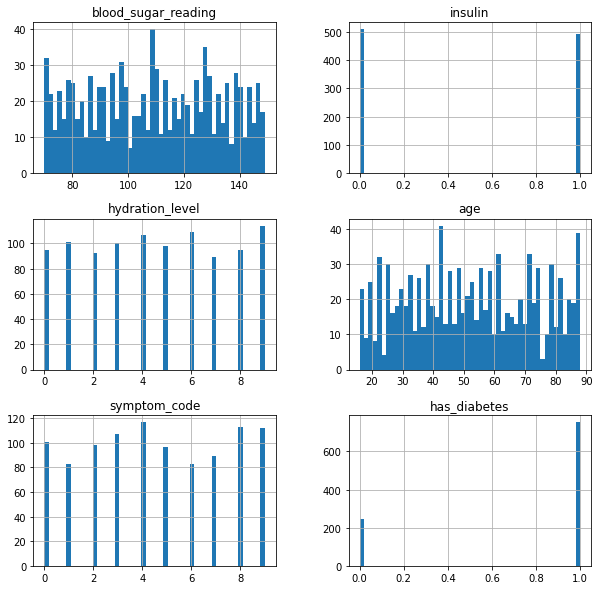

In [167]:
df_plot = df[['blood_sugar_reading','insulin','hydration_level','age',
              'symptom_code','has_diabetes']]
df_plot.hist(bins=50, figsize=(10,10))
plt.show()

### 5. Features selection

In [168]:
# define the columns used in our analysis
numerical_colums = [
  "blood_sugar_reading",
  "insulin",
  "age",
  "private_insurance",
  "has_diabetes"]

categorical_colums = [
  "hydration_level",
  "marital_status",
  "no_primary_dr",
  "symptom_code"]

# one hot encode the categorical variables
original_df = [pd.get_dummies(df[col], prefix=col) for col in categorical_colums]
original_df.append(df[numerical_colums])
original_df = pd.concat(original_df,axis=1)

original_df.head()

,hydration_level_0,hydration_level_1,hydration_level_2,hydration_level_3,hydration_level_4,hydration_level_5,hydration_level_6,hydration_level_7,hydration_level_8,hydration_level_9,marital_status_divorced,marital_status_married,marital_status_no_answer,marital_status_single,no_primary_dr_False,no_primary_dr_True,symptom_code_0,symptom_code_1,symptom_code_2,symptom_code_3,symptom_code_4,symptom_code_5,symptom_code_6,symptom_code_7,symptom_code_8,symptom_code_9,blood_sugar_reading,insulin,age,private_insurance,has_diabetes
0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,108,1,49,0,1
1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,70,1,82,0,1
2,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,100,1,71,0,1
3,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,113,1,87,1,1
4,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,93,0,53,0,1


### 6. Correlations between variables

Afin d'avoir un premier aperçu du pouvoir explicatif des features retenues, nous calculons la matrice des corrélations entre les différentes colonnes du dataframe qui sera utilisé pour réaliser nos analyses. S'agissant des variables catégorielles *marital status*, *hydration_level* et *symptom_code*, pouvant prendre repectivement 4, 10 et 10 modalités différentes, un one-hot encoding est réalisé. Les deux variables catégorielles *no_primary_dr* et *private_insurance* sont quant à elles laisées en l'état dans la mesure où elles prennent seulement deux modalités, à savoir False/True (traité comme 0/1) et 0/1, respectivement.

Plusieurs variables présentent un degré de corrélation non négligeable avec la présence d'un diabète (on indique la valeur du coefficient de corrélation entre parenthèses): *hydration_level* (jusqu'à 0.08), *no_primary_dr* (0.07) et *private_insurance* (-0.07).

In [169]:
# compute the correlation matrix
original_df.corr()

,hydration_level_0,hydration_level_1,hydration_level_2,hydration_level_3,hydration_level_4,hydration_level_5,hydration_level_6,hydration_level_7,hydration_level_8,hydration_level_9,marital_status_divorced,marital_status_married,marital_status_no_answer,marital_status_single,no_primary_dr_False,no_primary_dr_True,symptom_code_0,symptom_code_1,symptom_code_2,symptom_code_3,symptom_code_4,symptom_code_5,symptom_code_6,symptom_code_7,symptom_code_8,symptom_code_9,blood_sugar_reading,insulin,age,private_insurance,has_diabetes
hydration_level_0,1.000000,-0.108597,-0.103131,-0.107998,-0.112151,-0.106794,-0.113321,-0.101268,-0.104972,-0.116218,-0.024523,-0.006438,0.009854,0.021713,-0.028753,0.028753,-0.006734,0.026146,-0.015027,-0.068019,0.009390,0.009046,0.013784,0.030482,-0.007918,0.014707,0.026326,0.029061,-0.006759,0.046953,-0.028745
hydration_level_1,-0.108597,1.000000,-0.106692,-0.111727,-0.116024,-0.110482,-0.117234,-0.104765,-0.108597,-0.120231,-0.004986,0.026311,-0.008979,-0.013363,-0.018164,0.018164,-0.002214,-0.016636,0.012301,0.055752,-0.018760,-0.031363,0.007422,0.000128,0.016635,-0.024329,-0.027815,0.008683,-0.019142,-0.026416,-0.062831
hydration_level_2,-0.103131,-0.106692,1.000000,-0.106104,-0.110184,-0.104921,-0.111333,-0.099492,-0.103131,-0.114179,0.068610,-0.000187,-0.043068,-0.027466,-0.016693,0.016693,0.008129,-0.033059,-0.058372,0.035325,-0.018988,0.035960,-0.020517,0.022017,0.017529,0.007636,0.008018,-0.029510,-0.011596,0.022864,-0.027057
hydration_level_3,-0.107998,-0.111727,-0.106104,1.000000,-0.115384,-0.109872,-0.116588,-0.104187,-0.107998,-0.119568,0.012252,-0.016480,0.008866,-0.003824,-0.000678,0.000678,0.009956,-0.088202,0.069511,-0.018332,0.034223,-0.019147,-0.051955,0.024584,-0.003159,0.029595,0.033950,-0.034671,0.035918,0.010013,0.020123
hydration_level_4,-0.112151,-0.116024,-0.110184,-0.115384,1.000000,-0.114097,-0.121071,-0.108194,-0.112151,-0.124166,0.013541,-0.022566,0.035724,-0.024382,-0.027880,0.027880,0.023544,0.036574,-0.005288,-0.004699,0.014906,0.006788,-0.033783,0.005419,-0.011148,-0.030610,-0.033706,0.034658,0.040872,-0.024779,-0.012604
hydration_level_5,-0.106794,-0.110482,-0.104921,-0.109872,-0.114097,1.000000,-0.115288,-0.103026,-0.106794,-0.118235,-0.060980,0.040392,0.012508,0.007794,-0.013121,0.013121,0.001139,-0.001634,0.004480,-0.005288,0.068374,-0.005750,-0.050400,-0.043965,-0.022034,0.042917,0.021214,0.012002,-0.061242,0.023237,-0.014776
hydration_level_6,-0.113321,-0.117234,-0.111333,-0.116588,-0.121071,-0.115288,1.000000,-0.109323,-0.113321,-0.125461,-0.093516,0.053016,-0.030035,0.067768,0.023372,-0.023372,-0.010745,0.057609,-0.028946,-0.038025,-0.017501,0.047999,0.022716,-0.030438,0.017058,-0.012291,-0.062473,0.002388,0.016584,-0.030683,0.080571
hydration_level_7,-0.101268,-0.104765,-0.099492,-0.104187,-0.108194,-0.103026,-0.109323,1.000000,-0.101268,-0.112117,0.035450,0.006251,-0.012661,-0.029772,0.031437,-0.031437,0.035093,0.007803,-0.008528,-0.017303,-0.004513,-0.019378,0.071452,0.000974,-0.022818,-0.033052,0.023527,-0.005536,-0.017770,0.012131,0.023599
hydration_level_8,-0.104972,-0.108597,-0.103131,-0.107998,-0.112151,-0.106794,-0.113321,-0.101268,1.000000,-0.116218,-0.001019,-0.052423,0.009854,0.045187,0.019805,-0.019805,-0.018052,-0.023302,0.007915,0.042312,-0.022441,-0.014001,0.001422,0.006528,0.024400,-0.006921,0.006217,-0.059623,-0.041710,-0.048660,0.042524
hydration_level_9,-0.116218,-0.120231,-0.114179,-0.119568,-0.124166,-0.118235,-0.125461,-0.112117,-0.116218,1.000000,0.058146,-0.028341,0.015475,-0.043820,0.029606,-0.029606,-0.036694,0.028947,0.019346,0.018343,-0.042467,-0.011248,0.040352,-0.012664,-0.008766,0.012292,0.010126,0.037209,0.056706,0.017958,-0.021596


## Part Two: Determining the Approach for Protecting the Columns

You are the database manager at the health care provider asked to prepare the data to send to a machine learning consultant who will help give you a more detailed analysis. The consultant has signed all the necessary NDAs, but you have instructions to keep the private or potentially sensitive data to a minimum.

Based on the scenario and what you learned

- What methods will be most effective? 
- Have you considered potential data leakage within the *non-sensitive* columns?
- Is there other sensitive or secret data we should address?

Nous avons vu en cours deux techniques de protection de la privacy que sont la k-anonymity et la differential privacy. Il semblerait toutefois que la differential privacy soit plus robuste aux attaques que la k-anonymity et nous avons donc opté pour la première. Pour rappel, la differential privacy protège la privacy des individus présents dans une base en faisant en sorte que les éléments inférés à partir de cette base ne révèlent aucune information qui est spécifique à un individu en particulier.

Nous avons considéré le risque de fuite lié au fait que la combinaison des attributs non sensibles *age* et *marital_status*, éventuellement complétée par *no_primary_dr* et *private_insurance*, peut permettre la quasi-identification d'une personne. C'est la raison pour laquelle nous avons décidé de bruiter la colonne *age*.

## Part Three: Implement Data Protection for the Dataset

Now it's time to code! Feel free to utilize code from the previous notebooks to implement protection of at least two of the columns you chose as sensitive. 

- What was difficult to decide and implement?
- How might this relate to real problems in machine learning with sensitive data? 



Comme indiqué ci-dessus, nous avons décidé de protéger les colonnes sensibles *has_diabetes* et *insuline* via un mécanisme de type random response et de bruiter la colonne *age* pour éviter la possible ré-endification de la personne.

La première difficulté à été de déterminer la valeur des paramètres utilisés pour le bruitage, sachant qu'un niveau trop faible de bruit laisse fuiter de l'information et qu'un niveau excessif de bruit rend la base inutilisable à des fins de prédictions. Au niveau du mécanisme de random response, nous avons utilisé des valeurs de probabilité de 0.5 pour $p$ et $q$. Concernant le mécanisme de Laplace pour le bruitage de l'âge, nous avons utilisé une valeur de epsilon fixée à 10, de façon à obtenir des valeurs d'âges qui ne soient pas totalement aberrantes (très au-delà de 100 ans pour certaines, négatives pour d'autres).

### Data balancing

La seconde difficulté concerne le caractère déséquilibré des données. Comme illustré par les graphiques présentés plus haut, la base est déséquilibrée dans le sens où 75% environ des individus présentent un diabète et la moitié environ sont traités à l'insuline. Clairement, ces données ne sont pas représentatives de la population et ne constituent pas un échantillon aléatoire. Un classifieur entraîné sur cette base pourra fournir des prédictions erronnées lors d'un appel d'un individu lambda quant au fait de savoir si celui-ci a un diabète ou non. Nous avons implémenté un rééquilibrage par sous-échantillonnage aléatoire des individus présentant un diabète de façon à retenir une proportion identique d'individus diabétiques et non diabétiques. Les niveaux d'accuracy obtenus avec ce rééquilibrage étant très en-dessous des 65% demandés, nous n'avons finalement pas retenu cette solution et nous avons travaillé avec l'intégralité des données.

In [170]:
# Rééquilibrage des données
balancing = False

if balancing:
  df_class_0, df_class_1 = original_df[original_df['has_diabetes'] == 0], original_df[original_df['has_diabetes'] == 1]
  df_class_1 = df_class_1.sample(len(df_class_0))
  balanced_df = pd.concat([df_class_0, df_class_1], axis=0)
else:
  balanced_df = original_df

print('original df shape:', original_df.shape)
print('balanced df shape:', balanced_df.shape)


original df shape: (1000, 31)
balanced df shape: (1000, 31)


### Protecting data (encryption)

In [171]:
def process_value(value, p, q):
    """
    :param value: The value to apply the differentially private scheme to.
    :param     p: The probability of returning a random value instead of the true one
    :param     q: The probability of returning 1 when generating a random value
    :    returns: A new, differentially private value
    """

    x = np.random.uniform(0,1)
    if x <= p:
        y = np.random.uniform(0,1)
        if y <= q:
            return 0
        else:
            return 1
    else:
        return value


def simlap(n, b):
    """
    :param     n: The number of samples to draw
    :param     b: Scale of the distribution.
    :    returns: a vector of size n with noises sample from laplace dristribution.
    """
    return np.random.laplace(0, b, n)

In [172]:
# we encode the `insulin` and `has_diabetes` variables using differential privacy
p, q = 0.5, 0.5
encoded_df = balanced_df.copy()
encoded_df['has_diabetes'] = balanced_df['has_diabetes'].apply(lambda row: process_value(row, p, q))
encoded_df['insulin'] = balanced_df['insulin'].apply(lambda row: process_value(row, p, q))

# we encode the `age` variable using Laplace mechanism
epsilon = 10
delta = max(encoded_df['age']) - min(encoded_df['age'])
b = delta/epsilon
encoded_df['age'] = encoded_df['age'] + simlap(encoded_df.shape[0], b)

encoded_df.head()

,hydration_level_0,hydration_level_1,hydration_level_2,hydration_level_3,hydration_level_4,hydration_level_5,hydration_level_6,hydration_level_7,hydration_level_8,hydration_level_9,marital_status_divorced,marital_status_married,marital_status_no_answer,marital_status_single,no_primary_dr_False,no_primary_dr_True,symptom_code_0,symptom_code_1,symptom_code_2,symptom_code_3,symptom_code_4,symptom_code_5,symptom_code_6,symptom_code_7,symptom_code_8,symptom_code_9,blood_sugar_reading,insulin,age,private_insurance,has_diabetes
0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,108,0,58.750690,0,1
1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,70,1,80.385514,0,1
2,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,100,1,72.501049,0,1
3,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,113,1,90.437302,1,1
4,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,93,0,56.646395,0,1


## Bonus: machine learning from anonymized Dataset

Build a model that predicts the the diabetes statue of a new patient based on the anonymized database from part three. Compare with non anonymized dataset. (try to get more than 0.65 accuracy)

In [173]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix


def split_df(df, test_size):
    y = df['has_diabetes']
    X = df.loc[:, df.columns != 'has_diabetes']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    return ((X_train, y_train), (X_test, y_test))


def train(X_train, y_train):
    rnd_clf = RandomForestClassifier() # we train random forest classifier on the train data
    return rnd_clf.fit(X_train, y_train)


# the trained model is evaluated on both test (encoded_df) and original data set (balanced_df)
def evaluate(model, X_test, y_test):
    y_pred = model.predict(X_test)
    return [confusion_matrix(y_pred, y_test), accuracy_score(y_test, y_pred),
            precision_score(y_test, y_pred), recall_score(y_test, y_pred)]


def print_metrics(label, metrics):
    print(f"\n**evaluation of {label} set")
    print(f"\taccuracy:\t{int(metrics[1]*100)}%")
    print(f"\tprecision:\t{int(metrics[2]*100)}%")
    print(f"\trecall:\t\t{int(metrics[3]*100)}%")

In [174]:
# split the encoded dataset into train and test set
(X_train, y_train) , (X_test, y_test) = split_df(encoded_df, test_size=0.3)

# training model on encoded data set
model = train(X_train, y_train)

# evaluate on encoded train set
encoded_train_metrics = evaluate(model, X_train, y_train)

# evaluate on encoded test set
encoded_test_metrics = evaluate(model, X_test, y_test)

#evaluate on original set
(X_val, y_val), _ = split_df(balanced_df, test_size=0.1)
original_metrics = evaluate(model, X_val, y_val)


print_metrics("encoded train ", encoded_train_metrics)
print_metrics("encoded test ", encoded_test_metrics)
print_metrics("original", original_metrics)


**evaluation of encoded train  set
	accuracy:	100%
	precision:	100%
	recall:		100%

**evaluation of encoded test  set
	accuracy:	62%
	precision:	65%
	recall:		88%

**evaluation of original set
	accuracy:	73%
	precision:	84%
	recall:		80%


### Conclusion

Si l'utilisation de la differential privacy a  permis (on l'espère) d'éviter le risque d'identification d'un individu, le bruitage introduit se traduit par une dégradation significative de la qualité des prédictions.